# Import useful packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import gridspec
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from scipy import stats
import cv2
import warnings

warnings.filterwarnings("ignore")
join = os.path.join

# Random forest regression: permutation feature importance

## Read data
#### Remove eyes with self-reported macular degeneration, glaucoma, reflection artifacts at the fovea and poor VA (resultant N=273)

In [3]:
d = pd.read_csv(join('data', 'derivedDataAnonymised.csv'))
d = d[d.md == 'no']                            
d = d[d.glaucoma == 'no']
d = d[d.scaled_macula_intensity <= 5]
d = d[d.va <= 0.1]

## Hyperparameter tuning via 10-fold cross validation

### Data preparation

In [4]:
## define outcome (spherical equivalent refraction, SER)
y = np.float32(d.ser)

## define features aka predictors
age = np.float32(d.age)                                      

sex = pd.get_dummies(d['sex'], prefix = 'sex')               
femaleSex = np.array(sex['sex_Female'])                      # one-hot encode sex (female as reference)

dist = np.float32(d.adj_dist)                                # OD-fovea distance (corrected for magnification)

ODarea = np.float32(d.adj_od_area)                           # OD area (corrected for magnification)

FPI = np.float32(d.scaled_macula_intensity)                  # foveal pixel intensity

orientation = np.float32(d.orientation)                      # OD orientation

tilt = np.float32(d.major_length)/np.float32(d.minor_length) # OD tilt

angle = np.float32(d.vertical_angle)

predictorNames = np.array(("age", 'sex', "OD-fovea distance", "OD area", "FPI", "OD orientation", "OD tilt", 'OD-fovea angle'))

## concatenate predictors into array of shape (N observations, no. of predictors)
x = np.vstack((age, femaleSex, dist, ODarea, FPI, orientation, tilt, angle))
x = np.moveaxis(x, 0,1)
print(x.shape)                                               # 273 rows (eyes) & 8 columns (predictors)


## Train/test split (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10) 
scale = StandardScaler()                                     # initiate function that standardises features (0 mean & unit variance) 
x_train = scale.fit_transform(x_train)                       # standardise features in the training set
x_test = scale.fit_transform(x_test)                         # standardise features in the test set


(273, 8)


### Exhaustive grid search to find the best combination of hyperparameter values

In [4]:
## hyperparameters and their respective values to be searched
param_grid = {
    'max_depth': [1,2,3,4,5],
    'max_features' : [2,3,4,5,6,7],
    'n_estimators': [35,40,45,50,55,60,65],
    'min_samples_leaf':[2,4,6,8,10],
    'min_samples_split':[15,17,19],
    'ccp_alpha':[0,0.005,0.01,0.05]}

## Begin grid search (10-fold cross validation) using mean absolute error as the loss function
grid_search = GridSearchCV(estimator = RandomForestRegressor(criterion="absolute_error", random_state=100), 
                           param_grid = param_grid,
                           cv = KFold(n_splits=10, shuffle=True),
                           n_jobs=40)
grid_search.fit(x_train, y_train)

## Return best combination of hyperparameter values
grid_search.best_params_

# ccp_alpha: complexity parameter used for minimal cost-complexity pruning
# max_depth: maximum depth of a decision tree
# max_features: maximum number of features at each split
# min_samples_leaf: minimum number of samples required at a leaf node
# min_samples_split: minimum number of samples required to split an internal node
# n_estimators: number of decision trees

{'ccp_alpha': 0.01,
 'max_depth': 5,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 15,
 'n_estimators': 35}

# Compute permutation feature importance

#### Initialise empty dataframe and a random forest regressor

In [5]:
## initialise dataframe to store results
# trainR2: training set r-squared
# testR2: test set r-squared
# baselineTestMAE: test mean absolute error when prediction was made using training set's mean values
# trainMAE: mean absolute error on the training set
# testMAE: mean absolute error on the test set
metricNames = np.array(['trainR2', 'testR2', 'baselineTestMAE', 'trainMAE', 'testMAE'])
columnNames = np.append(predictorNames, metricNames)
df = pd.DataFrame(columns=columnNames)

## initialise a random forest regressor using the hyperparameter values tuned above
regr = RandomForestRegressor(max_depth=5,
                             ccp_alpha=0.01,
                             max_features=3,
                             min_samples_leaf = 4,
                             min_samples_split = 15,
                             n_estimators=35,
                             random_state=100, 
                             warm_start=True,
                             criterion="absolute_error")

#### Split the data into 80/20 train/test sets. Then, fit the initialised regressor to the training set and compute permutation feature importance scores on the test set. Repeat this 100 times (each time with a new combination of training and test sets) and take the mean feature importance scores as the final scores.


In [6]:
for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20) # train/test split
    x_train = scale.fit_transform(x_train)                                    # standardise features in the training set
    x_test = scale.fit_transform(x_test)                                      # standardise features in the test set
    regr.fit(x_train, y_train)                                                # fit the regressor to the training set
    
    print('=================================', 'Iteration: ', i, '=================================')
    trainR2 = regr.score(x_train, y_train).mean()                             
    testR2 = regr.score(x_test, y_test).mean()
    baselineTestMAE = np.mean(abs(np.mean(y_train) - y_test))
    trainMAE = np.mean(abs(regr.predict(x_train) - y_train))
    testMAE = np.mean(abs(regr.predict(x_test) - y_test))
    
    ## compute feature importance (on the test set) via 100 random permutations 
    result = permutation_importance(regr, 
                                    x_test, 
                                    y_test, 
                                    n_repeats=100, 
                                    random_state=100, 
                                    n_jobs=2, 
                                    scoring="neg_mean_absolute_error")                
    
    ## record permutation feature importance scores at each iteration
    data = np.concatenate( (result.importances_mean, np.array((trainR2, testR2, baselineTestMAE, trainMAE, testMAE))) )
    newDf = pd.DataFrame(columns=columnNames, data=data[None, :])
    df = df.append(newDf)
    df.to_csv(join('results', 'featureImportance.csv'))

    
    

================================= Iteration:  0 =================================
================================= Iteration:  1 =================================
================================= Iteration:  2 =================================
================================= Iteration:  3 =================================
================================= Iteration:  4 =================================
================================= Iteration:  5 =================================
================================= Iteration:  6 =================================
================================= Iteration:  7 =================================
================================= Iteration:  8 =================================
================================= Iteration:  9 =================================
================================= Iteration:  10 =================================
================================= Iteration:  11 =================================
==============

================================= Iteration:  99 =================================


### Plot feature importance scores

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'OD-fovea distance'),
  Text(1, 0, 'age'),
  Text(2, 0, 'OD orientation'),
  Text(3, 0, 'OD area'),
  Text(4, 0, 'OD-fovea angle'),
  Text(5, 0, 'FPI'),
  Text(6, 0, 'OD tilt'),
  Text(7, 0, 'sex')])

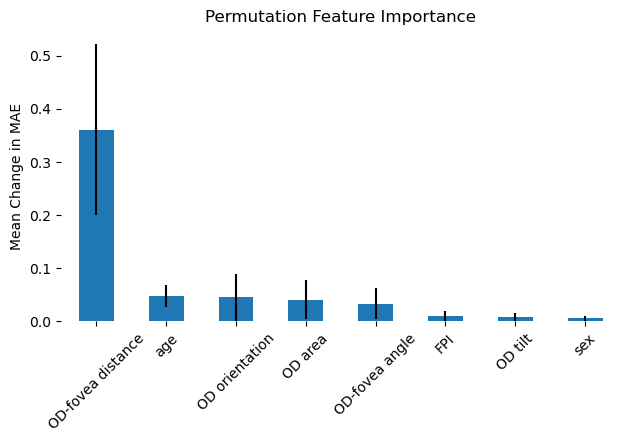

In [7]:
## Compute mean scores (across iterations) and take these as the final scores
meanScores = [np.mean(df[predictorNames[0]]),
              np.mean(df[predictorNames[1]]),
              np.mean(df[predictorNames[2]]),
              np.mean(df[predictorNames[3]]),
              np.mean(df[predictorNames[4]]),
              np.mean(df[predictorNames[5]]),
              np.mean(df[predictorNames[6]]),
              np.mean(df[predictorNames[7]])]    
meanScores = np.array(meanScores)

## Order features by their final importance scores
order = (-meanScores).argsort()
forest_importances = pd.Series((meanScores)[order], index=predictorNames[order])

## Plot
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=np.array(np.std(df[predictorNames[order]])), ax=ax)
ax.set_title("Permutation Feature Importance")
ax.set_ylabel("Mean Change in MAE")
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.tight_layout()
plt.xticks(rotation = 45)

### Mean test MAE achieved by the model vs baseline test MAE 

In [36]:
print('Train r-squared is:', np.mean(df.trainR2))
print('Test r-squared is:', np.mean(df.testR2))
print('Baseline MAE is:', np.mean(df.baselineTestMAE))
print('Test MAE is:', np.mean(df.testMAE))

Train r-squared is: 0.3902943772503542
Test r-squared is: 0.30935165318742186
Baseline MAE is: 1.7643334865570068
Test MAE is: 1.4422450476084858


In [37]:
tresult = stats.ttest_rel(df.testMAE, df.baselineTestMAE)
meanDiff = round(np.mean(df.testMAE) - np.mean(df.baselineTestMAE),2)
lowCI = round(tresult.confidence_interval()[0],2)
highCI = round(tresult.confidence_interval()[1],2)
p = round(tresult.pvalue,5)
print('t stat:', round(tresult.statistic,2), '| mean diff:', meanDiff, '| 95% CI:', lowCI, 'to', highCI, '| p:', p)

t stat: -19.24 | mean diff: -0.32 | 95% CI: -0.36 to -0.29 | p: 0.0


#### OD-fovea distance feature importance score

In [38]:
np.mean(df['OD-fovea distance'])

0.3606280696587623

#### Aggregate importance score for all other features

In [39]:
np.mean(df['sex']) + np.mean(df['OD tilt']) + np.mean(df['age']) + np.mean(df['OD orientation']) + np.mean(df['OD-fovea angle']) + np.mean(df['FPI']) + np.mean(df['OD area'])

0.19065220814345704

# Construct "eigendiscs"
#### Note: the following section cannot be reproduced using the data provided ('derivedDataAnonymised.csv'), as the code assumes that image names are recorded per UK Biobank standard format (replaced with simple indexing) and that the masked raw images are available (cannot be shared due to UK Biobank access control policy)

In [14]:
names1 = d[d.ser > +3].name                                 # SER more hyperopic than +3.00 D
names2 = d[(d.ser <= +3) * (d.ser > +1.50)].name            # SER between +1.50 D and +3.00 D
names3 = d[(d.ser <= +1.50) * (d.ser > -0.25)].name         # SER between -0.25 D and +1.50 D
names4 = d[(d.ser < -0.25) * (d.ser >= -1.50)].name         # SER between -0.25 D and -1.50 D
names5 = d[(d.ser < -1.50) * (d.ser >= -3)].name            # SER between -1.50 D and -3.00 D
names6 = d[(d.ser < -3) * (d.ser >= -5.00)].name            # SER between -3.00 D and -5.00 D
names7 = d[d.ser < -5].name                                 # SER more myopic than -5.00 D

### Define useful functions

In [17]:
## min max normalisation
def minmax(x):
    return (x- x.min()) / (x.max() - x.min())

## Generate 3 eigendiscs
def generateEigendiscs(names, eye):
    w = 120
    images = []
    finalNames = []
    for name in names:
        if eye =="LE":
            if name[11:13] == "15":
                finalNames.append(name)
        if eye == "RE":
            if name[11:13] == "16":
                finalNames.append(name)
    
    for name in finalNames:
        I = plt.imread(join('ODMA_masks_manual', name))
        
        x = round(d.disc_x.iloc[np.where(d.name == name)[0][0]])
        y = round(d.disc_y.iloc[np.where(d.name == name)[0][0]])
        
        imin = max(0,y-w)
        imax = min(I.shape[0],y+w+1)
        jmin = max(0,x-w)
        jmax = min(I.shape[1],x+w+1) 
        I = I[imin:imax,jmin:jmax]
        images.append(I.flatten())
    images = np.array(images) 
        
    if __name__ == '__main__':
        # Number of eigendiscs
        NUM_EIGEN_DISCS = 3
        # Size of images
        sz = I.shape
        # Compute the eigenvectors from the stack of images created
        print("Calculating PCA ", end="...")
        mean, eigenVectors = cv2.PCACompute ( images, mean=None, maxComponents=NUM_EIGEN_DISCS )
        print ("DONE")
        averageFace = mean.reshape(sz)
        eigendiscs = [];     
        for eigenVector in eigenVectors:
            eigendisc = eigenVector.reshape(sz)
            eigendiscs.append(eigendisc)
    return eigendiscs, mean

## Plot eigendiscs by refractive error
def plotEigendiscs(eigendiscs, name):
    nrow = len(eigendiscs)
    
    gs = gridspec.GridSpec(nrow, 3, width_ratios=[1, 1, 1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.35, right=0.65)
    
    for row, i in enumerate(eigendiscs):
        ef1_RGB = minmax(i[0])
        ef2_RGB = minmax(i[1])
        ef3_RGB = minmax(i[2])

        ef1 = cv2.cvtColor(ef1_RGB, cv2.COLOR_BGR2GRAY)
        ef2 = cv2.cvtColor(ef2_RGB, cv2.COLOR_BGR2GRAY)
        ef3 = cv2.cvtColor(ef3_RGB, cv2.COLOR_BGR2GRAY)
        
        ax1 = plt.subplot(gs[row,0])
        ax1.imshow(ef1, cmap='gray'); plt.axis('off')
        
        ax2 = plt.subplot(gs[row,1])
        ax2.imshow(ef2, cmap='gray'); plt.axis('off')
        
        ax3 = plt.subplot(gs[row,2])
        ax3.imshow(ef3, cmap='gray'); plt.axis('off')
          
    plt.savefig('eigenDiscs/' + name)
    plt.show()    
    

### Construct right eye eigendiscs

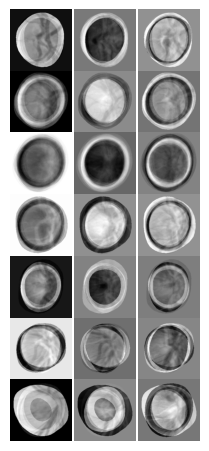

In [278]:
eigenDiscs1 = generateEigendiscs(eye="RE", names=names1)
eigenDiscs2 = generateEigendiscs(eye="RE", names=names2)
eigenDiscs3 = generateEigendiscs(eye="RE", names=names3)
eigenDiscs4 = generateEigendiscs(eye="RE", names=names4)
eigenDiscs5 = generateEigendiscs(eye="RE", names=names5)
eigenDiscs6 = generateEigendiscs(eye="RE", names=names6)
eigenDiscs7 = generateEigendiscs(eye="RE", names=names7)

eigenDiscsRE = [eigenDiscs1[0], eigenDiscs2[0], eigenDiscs3[0], eigenDiscs4[0], eigenDiscs5[0], eigenDiscs6[0], eigenDiscs7[0]]

# Top to bottom: hyperopia to myopia with increasing magnitude
plotEigendiscs(eigenDiscsRE, 'RE')

### Construct left eye eigendiscs

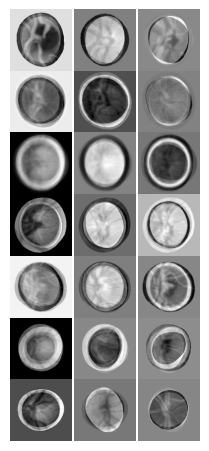

In [279]:
eigenDiscs1 = generateEigendiscs(eye="LE", names=names1)
eigenDiscs2 = generateEigendiscs(eye="LE", names=names2)
eigenDiscs3 = generateEigendiscs(eye="LE", names=names3)
eigenDiscs4 = generateEigendiscs(eye="LE", names=names4)
eigenDiscs5 = generateEigendiscs(eye="LE", names=names5)
eigenDiscs6 = generateEigendiscs(eye="LE", names=names6)
eigenDiscs7 = generateEigendiscs(eye="LE", names=names7)

eigenDiscsLE = [eigenDiscs1[0], eigenDiscs2[0], eigenDiscs3[0], eigenDiscs4[0], eigenDiscs5[0], eigenDiscs6[0], eigenDiscs7[0]]

# Top to bottom: hyperopia to myopia with increasing magnitude
plotEigendiscs(eigenDiscsLE, 'LE')